# GAT (PPI)

The GAT model is trained on PPI datasets to verify the author's claim that the model works on inductive learning problems. Micro-F1 score are used to measure the model performance. 
For the PPI dataset, the GAT model is trained on the first 20 graphs, and the performance metric mico-F1 score is measured on the 2 test graphs. 
The results of the reproducibility study support the author’s claim. The reproduced results are same as the author’s results with acceptable error (within 2%)


In [1]:
# I always like to structure my imports into Python's native libs,
# stuff I installed via conda/pip and local file imports (but we don't have those here)

import json
import os
import enum
import zipfile
import pickle

# Visualization related imports
import matplotlib.pyplot as plt
import networkx as nx
from networkx.readwrite import json_graph
import igraph as ig

# Main computation libraries
import numpy as np

# Deep learning related imports
import torch
from torch.utils.data import DataLoader, Dataset
from torch.hub import download_url_to_file

In [8]:
"""
    Contains constants needed for data loading and visualization.

"""


# Supported datasets - only PPI in this notebook
class DatasetType(enum.Enum):
    PPI = 0

    
class GraphVisualizationTool(enum.Enum):
    IGRAPH = 0


# We'll be dumping and reading the data from this directory
DATA_DIR_PATH = os.path.join(os.getcwd(), 'data')
PPI_PATH = os.path.join(DATA_DIR_PATH, 'ppi')
PPI_URL = 'https://data.dgl.ai/dataset/ppi.zip'  # preprocessed PPI data from Deep Graph Library

#
# PPI specific constants
#

PPI_NUM_INPUT_FEATURES = 50
PPI_NUM_CLASSES = 121

num_node = [1767, 1377, 2263, 2339, 1578, 1021, 1823, 2488, 591, 3312, 2401, 1878, 1819, 3480, 2794, 2326, 2650, 2815, 3163, 3021, 3230, 3284, 3224, 2300]
num_edge = [34085, 31081, 61907, 67769, 37740, 19237, 46153, 72878, 8299, 109510, 66619, 48146, 47587, 110234, 88112, 62188, 79714, 88335, 97321, 94359, 100676, 104758, 103872, 63628]

# Part 1: Data Summary

In [3]:
# First let's define this simple function for loading PPI's graph data

def json_read(path):
    with open(path, 'r') as file:
        data = json.load(file)

    return data

In [4]:
def load_graph_data(training_config, device):
    dataset_name = training_config['dataset_name'].lower()
    should_visualize = training_config['should_visualize']

    if dataset_name == DatasetType.PPI.name.lower():  # Protein-Protein Interaction dataset

        # Instead of checking PPI in, I'd rather download it on-the-fly the first time it's needed (lazy execution ^^)
        if not os.path.exists(PPI_PATH):  # download the first time this is ran
            os.makedirs(PPI_PATH)

            # Step 1: Download the ppi.zip (contains the PPI dataset)
            zip_tmp_path = os.path.join(PPI_PATH, 'ppi.zip')
            download_url_to_file(PPI_URL, zip_tmp_path)

            # Step 2: Unzip it
            with zipfile.ZipFile(zip_tmp_path) as zf:
                zf.extractall(path=PPI_PATH)
            print(f'Unzipping to: {PPI_PATH} finished.')

            # Step3: Remove the temporary resource file
            os.remove(zip_tmp_path)
            print(f'Removing tmp file {zip_tmp_path}.')

        # Collect train/val/test graphs here
        edge_index_list = []
        node_features_list = []
        node_labels_list = []

        # Dynamically determine how many graphs we have per split (avoid using constants when possible)
        num_graphs_per_split_cumulative = [0]

        # Small optimization "trick" since we only need test in the playground.py
        splits = ['test'] if training_config['ppi_load_test_only'] else ['train', 'valid', 'test']

        for split in splits:
            # PPI has 50 features per node, it's a combination of positional gene sets, motif gene sets,
            # and immunological signatures - you can treat it as a black box (I personally have a rough understanding)
            # shape = (NS, 50) - where NS is the number of (N)odes in the training/val/test (S)plit
            # Note: node features are already preprocessed
            node_features = np.load(os.path.join(PPI_PATH, f'{split}_feats.npy'))

            # PPI has 121 labels and each node can have multiple labels associated (gene ontology stuff)
            # SHAPE = (NS, 121)
            node_labels = np.load(os.path.join(PPI_PATH, f'{split}_labels.npy'))

            # Graph topology stored in a special nodes-links NetworkX format
            nodes_links_dict = json_read(os.path.join(PPI_PATH, f'{split}_graph.json'))
            # PPI contains undirected graphs with self edges - 20 train graphs, 2 validation graphs and 2 test graphs
            # The reason I use a NetworkX's directed graph is because we need to explicitly model both directions
            # because of the edge index and the way GAT implementation #3 works
            collection_of_graphs = nx.DiGraph(json_graph.node_link_graph(nodes_links_dict))
            # For each node in the above collection, ids specify to which graph the node belongs to
            graph_ids = np.load(os.path.join(PPI_PATH, F'{split}_graph_id.npy'))
            num_graphs_per_split_cumulative.append(num_graphs_per_split_cumulative[-1] + len(np.unique(graph_ids)))

            # Split the collection of graphs into separate PPI graphs
            for graph_id in range(np.min(graph_ids), np.max(graph_ids) + 1):
                mask = graph_ids == graph_id  # find the nodes which belong to the current graph (identified via id)
                graph_node_ids = np.asarray(mask).nonzero()[0]
                graph = collection_of_graphs.subgraph(graph_node_ids)  # returns the induced subgraph over these nodes
                print(f'Loading {split} graph {graph_id} to CPU. '
                      f'It has {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges.')

                # shape = (2, E) - where E is the number of edges in the graph
                # Note: leaving the tensors on CPU I'll load them to GPU in the training loop on-the-fly as VRAM
                # is a scarcer resource than CPU's RAM and the whole PPI dataset can't fit during the training.
                edge_index = torch.tensor(list(graph.edges), dtype=torch.long).transpose(0, 1).contiguous()
                edge_index = edge_index - edge_index.min()  # bring the edges to [0, num_of_nodes] range
                edge_index_list.append(edge_index)
                # shape = (N, 50) - where N is the number of nodes in the graph
                node_features_list.append(torch.tensor(node_features[mask], dtype=torch.float))
                # shape = (N, 121), BCEWithLogitsLoss doesn't require long/int64 so saving some memory by using float32
                node_labels_list.append(torch.tensor(node_labels[mask], dtype=torch.float))

                if should_visualize:
                    plot_in_out_degree_distributions(edge_index.numpy(), graph.number_of_nodes(), dataset_name)
                    visualize_graph(edge_index.numpy(), node_labels[mask], dataset_name)

        #
        # Prepare graph data loaders
        #

        # Optimization, do a shortcut in case we only need the test data loader
        if training_config['ppi_load_test_only']:
            data_loader_test = GraphDataLoader(
                node_features_list[num_graphs_per_split_cumulative[0]:num_graphs_per_split_cumulative[1]],
                node_labels_list[num_graphs_per_split_cumulative[0]:num_graphs_per_split_cumulative[1]],
                edge_index_list[num_graphs_per_split_cumulative[0]:num_graphs_per_split_cumulative[1]],
                batch_size=training_config['batch_size'],
                shuffle=False
            )
            return data_loader_test
        else:

            data_loader_train = GraphDataLoader(
                node_features_list[num_graphs_per_split_cumulative[0]:num_graphs_per_split_cumulative[1]],
                node_labels_list[num_graphs_per_split_cumulative[0]:num_graphs_per_split_cumulative[1]],
                edge_index_list[num_graphs_per_split_cumulative[0]:num_graphs_per_split_cumulative[1]],
                batch_size=training_config['batch_size'],
                shuffle=True
            )

            data_loader_val = GraphDataLoader(
                node_features_list[num_graphs_per_split_cumulative[1]:num_graphs_per_split_cumulative[2]],
                node_labels_list[num_graphs_per_split_cumulative[1]:num_graphs_per_split_cumulative[2]],
                edge_index_list[num_graphs_per_split_cumulative[1]:num_graphs_per_split_cumulative[2]],
                batch_size=training_config['batch_size'],
                shuffle=False  # no need to shuffle the validation and test graphs
            )

            data_loader_test = GraphDataLoader(
                node_features_list[num_graphs_per_split_cumulative[2]:num_graphs_per_split_cumulative[3]],
                node_labels_list[num_graphs_per_split_cumulative[2]:num_graphs_per_split_cumulative[3]],
                edge_index_list[num_graphs_per_split_cumulative[2]:num_graphs_per_split_cumulative[3]],
                batch_size=training_config['batch_size'],
                shuffle=False
            )

            return data_loader_train, data_loader_val, data_loader_test
    else:
        raise Exception(f'{dataset_name} not yet supported.')

In [5]:
class GraphDataLoader(DataLoader):
    """
    When dealing with batches it's always a good idea to inherit from PyTorch's provided classes (Dataset/DataLoader).

    """
    def __init__(self, node_features_list, node_labels_list, edge_index_list, batch_size=1, shuffle=False):
        graph_dataset = GraphDataset(node_features_list, node_labels_list, edge_index_list)
        # We need to specify a custom collate function, it doesn't work with the default one
        super().__init__(graph_dataset, batch_size, shuffle, collate_fn=graph_collate_fn)


class GraphDataset(Dataset):
    """
    This one just fetches a single graph from the split when GraphDataLoader "asks" it

    """
    def __init__(self, node_features_list, node_labels_list, edge_index_list):
        self.node_features_list = node_features_list
        self.node_labels_list = node_labels_list
        self.edge_index_list = edge_index_list

    # 2 interface functions that need to be defined are len and getitem so that DataLoader can do it's magic
    def __len__(self):
        return len(self.edge_index_list)

    def __getitem__(self, idx):  # we just fetch a single graph
        return self.node_features_list[idx], self.node_labels_list[idx], self.edge_index_list[idx]


def graph_collate_fn(batch):
    """
    The main idea here is to take multiple graphs from PPI as defined by the batch size
    and merge them into a single graph with multiple connected components.

    It's important to adjust the node ids in edge indices such that they form a consecutive range. Otherwise
    the scatter functions in the implementation 3 will fail.

    :param batch: contains a list of edge_index, node_features, node_labels tuples (as provided by the GraphDataset)
    """

    edge_index_list = []
    node_features_list = []
    node_labels_list = []
    num_nodes_seen = 0

    for features_labels_edge_index_tuple in batch:
        # Just collect these into separate lists
        node_features_list.append(features_labels_edge_index_tuple[0])
        node_labels_list.append(features_labels_edge_index_tuple[1])

        edge_index = features_labels_edge_index_tuple[2]  # all of the components are in the [0, N] range
        edge_index_list.append(edge_index + num_nodes_seen)  # very important! translate the range of this component
        num_nodes_seen += len(features_labels_edge_index_tuple[1])  # update the number of nodes we've seen so far

    # Merge the PPI graphs into a single graph with multiple connected components
    node_features = torch.cat(node_features_list, 0)
    node_labels = torch.cat(node_labels_list, 0)
    edge_index = torch.cat(edge_index_list, 1)

    return node_features, node_labels, edge_index

In [6]:
# Let's just define dummy visualization functions for now - just to stop Python interpreter from complaining!
# We'll define them in a moment, properly, I swear.

def plot_in_out_degree_distributions():
    pass

def visualize_graph():
    pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # checking whether you have a GPU

config = {
    'dataset_name': DatasetType.PPI.name,
    'should_visualize': False,
    'batch_size': 1,
    'ppi_load_test_only': False  # small optimization for loading test graphs only, we won't use it here
}

data_loader_train, data_loader_val, data_loader_test = load_graph_data(config, device)
# Let's fetch a single batch from the train graph data loader
node_features, node_labels, edge_index = next(iter(data_loader_train))

print('*' * 20)
print(node_features.shape, node_features.dtype)
print(node_labels.shape, node_labels.dtype)
print(edge_index.shape, edge_index.dtype)

Loading train graph 1 to CPU. It has 1767 nodes and 34085 edges.
Loading train graph 2 to CPU. It has 1377 nodes and 31081 edges.
Loading train graph 3 to CPU. It has 2263 nodes and 61907 edges.
Loading train graph 4 to CPU. It has 2339 nodes and 67769 edges.
Loading train graph 5 to CPU. It has 1578 nodes and 37740 edges.
Loading train graph 6 to CPU. It has 1021 nodes and 19237 edges.
Loading train graph 7 to CPU. It has 1823 nodes and 46153 edges.
Loading train graph 8 to CPU. It has 2488 nodes and 72878 edges.
Loading train graph 9 to CPU. It has 591 nodes and 8299 edges.
Loading train graph 10 to CPU. It has 3312 nodes and 109510 edges.
Loading train graph 11 to CPU. It has 2401 nodes and 66619 edges.
Loading train graph 12 to CPU. It has 1878 nodes and 48146 edges.
Loading train graph 13 to CPU. It has 1819 nodes and 47587 edges.
Loading train graph 14 to CPU. It has 3480 nodes and 110234 edges.
Loading train graph 15 to CPU. It has 2794 nodes and 88112 edges.
Loading train graph

Text(0.5, 1.0, 'Number of nodes for each graph')

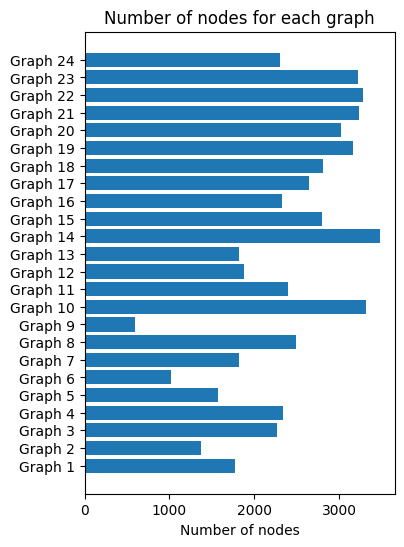

In [77]:
num_graph = ['Graph '+ str(x+1) for x in range(24)]
fig = plt.figure(figsize=(4,6))

# We can set the number of bins with the *bins* keyword argument.
plt.subplot()
plt.barh(num_graph, num_node, align='center')
plt.xlabel('Number of nodes')
plt.title('Number of nodes for each graph')



1. This specific PPI train graph (graph 1) has 1767 nodes 
2. Each node has **50 features** 
3. PPI has **121 classes** and each node can have multiple classes associated with it (multi-label classification dataset)
4. This graph has 34085 edges (including the self edges)! (Compare this to 13k edges in Cora)
5. PPI has **20 train** graphs, **2 validation** graphs and **2 test** graphs


# Part 2: GAT Model

In [9]:
import torch.nn as nn
from torch.optim import Adam


class GAT(torch.nn.Module):
    """
    The most interesting and hardest implementation is implementation #3.
    Imp1 and imp2 differ in subtle details but are basically the same thing.

    So I'll focus on imp #3 in this notebook.

    """

    def __init__(self, num_of_layers, num_heads_per_layer, num_features_per_layer, add_skip_connection=True, bias=True,
                 dropout=0.6, log_attention_weights=False):
        super().__init__()
        assert num_of_layers == len(num_heads_per_layer) == len(num_features_per_layer) - 1, f'Enter valid arch params.'

        num_heads_per_layer = [1] + num_heads_per_layer  # trick - so that I can nicely create GAT layers below

        gat_layers = []  # collect GAT layers
        for i in range(num_of_layers):
            layer = GATLayer(
                num_in_features=num_features_per_layer[i] * num_heads_per_layer[i],  # consequence of concatenation
                num_out_features=num_features_per_layer[i+1],
                num_of_heads=num_heads_per_layer[i+1],
                concat=True if i < num_of_layers - 1 else False,  # last GAT layer does mean avg, the others do concat
                activation=nn.ELU() if i < num_of_layers - 1 else None,  # last layer just outputs raw scores
                dropout_prob=dropout,
                add_skip_connection=add_skip_connection,
                bias=bias,
                log_attention_weights=log_attention_weights
            )
            gat_layers.append(layer)

        self.gat_net = nn.Sequential(
            *gat_layers,
        )

    # data is just a (in_nodes_features, edge_index) tuple, I had to do it like this because of the nn.Sequential:
    # https://discuss.pytorch.org/t/forward-takes-2-positional-arguments-but-3-were-given-for-nn-sqeuential-with-linear-layers/65698
    def forward(self, data):
        return self.gat_net(data)

In [10]:
class GATLayer(torch.nn.Module):
    """
    Implementation #3 was inspired by PyTorch Geometric: https://github.com/rusty1s/pytorch_geometric

    But, it's hopefully much more readable! (and of similar performance)

    """
    
    # We'll use these constants in many functions so just extracting them here as member fields
    src_nodes_dim = 0  # position of source nodes in edge index
    trg_nodes_dim = 1  # position of target nodes in edge index

    # These may change in the inductive setting - leaving it like this for now (not future proof)
    nodes_dim = 0      # node dimension (axis is maybe a more familiar term nodes_dim is the position of "N" in tensor)
    head_dim = 1       # attention head dim

    def __init__(self, num_in_features, num_out_features, num_of_heads, concat=True, activation=nn.ELU(),
                 dropout_prob=0.6, add_skip_connection=True, bias=True, log_attention_weights=False):

        super().__init__()

        self.num_of_heads = num_of_heads
        self.num_out_features = num_out_features
        self.concat = concat  # whether we should concatenate or average the attention heads
        self.add_skip_connection = add_skip_connection

        #
        # Trainable weights: linear projection matrix (denoted as "W" in the paper), attention target/source
        # (denoted as "a" in the paper) and bias (not mentioned in the paper but present in the official GAT repo)
        #

        # You can treat this one matrix as num_of_heads independent W matrices
        self.linear_proj = nn.Linear(num_in_features, num_of_heads * num_out_features, bias=False)

        # After we concatenate target node (node i) and source node (node j) we apply the "additive" scoring function
        # which gives us un-normalized score "e". Here we split the "a" vector - but the semantics remain the same.
        # Basically instead of doing [x, y] (concatenation, x/y are node feature vectors) and dot product with "a"
        # we instead do a dot product between x and "a_left" and y and "a_right" and we sum them up
        self.scoring_fn_target = nn.Parameter(torch.Tensor(1, num_of_heads, num_out_features))
        self.scoring_fn_source = nn.Parameter(torch.Tensor(1, num_of_heads, num_out_features))

        # Bias is definitely not crucial to GAT - feel free to experiment (I pinged the main author, Petar, on this one)
        if bias and concat:
            self.bias = nn.Parameter(torch.Tensor(num_of_heads * num_out_features))
        elif bias and not concat:
            self.bias = nn.Parameter(torch.Tensor(num_out_features))
        else:
            self.register_parameter('bias', None)

        if add_skip_connection:
            self.skip_proj = nn.Linear(num_in_features, num_of_heads * num_out_features, bias=False)
        else:
            self.register_parameter('skip_proj', None)

        #
        # End of trainable weights
        #

        self.leakyReLU = nn.LeakyReLU(0.2)  # using 0.2 as in the paper, no need to expose every setting
        self.activation = activation
        # Probably not the nicest design but I use the same module in 3 locations, before/after features projection
        # and for attention coefficients. Functionality-wise it's the same as using independent modules.
        self.dropout = nn.Dropout(p=dropout_prob)

        self.log_attention_weights = log_attention_weights  # whether we should log the attention weights
        self.attention_weights = None  # for later visualization purposes, I cache the weights here

        self.init_params()
        
    def forward(self, data):
        #
        # Step 1: Linear Projection + regularization
        #

        in_nodes_features, edge_index = data  # unpack data
        num_of_nodes = in_nodes_features.shape[self.nodes_dim]
        assert edge_index.shape[0] == 2, f'Expected edge index with shape=(2,E) got {edge_index.shape}'

        # shape = (N, FIN) where N - number of nodes in the graph, FIN - number of input features per node
        # We apply the dropout to all of the input node features (as mentioned in the paper)
        in_nodes_features = self.dropout(in_nodes_features)

        # shape = (N, FIN) * (FIN, NH*FOUT) -> (N, NH, FOUT) where NH - number of heads, FOUT - num of output features
        # We project the input node features into NH independent output features (one for each attention head)
        nodes_features_proj = self.linear_proj(in_nodes_features).view(-1, self.num_of_heads, self.num_out_features)

        nodes_features_proj = self.dropout(nodes_features_proj)  # in the official GAT imp they did dropout here as well

        #
        # Step 2: Edge attention calculation
        #

        # Apply the scoring function (* represents element-wise (a.k.a. Hadamard) product)
        # shape = (N, NH, FOUT) * (1, NH, FOUT) -> (N, NH, 1) -> (N, NH) because sum squeezes the last dimension
        # Optimization note: torch.sum() is as performant as .sum() in my experiments
        scores_source = (nodes_features_proj * self.scoring_fn_source).sum(dim=-1)
        scores_target = (nodes_features_proj * self.scoring_fn_target).sum(dim=-1)

        # We simply copy (lift) the scores for source/target nodes based on the edge index. Instead of preparing all
        # the possible combinations of scores we just prepare those that will actually be used and those are defined
        # by the edge index.
        # scores shape = (E, NH), nodes_features_proj_lifted shape = (E, NH, FOUT), E - number of edges in the graph
        scores_source_lifted, scores_target_lifted, nodes_features_proj_lifted = self.lift(scores_source, scores_target, nodes_features_proj, edge_index)
        scores_per_edge = self.leakyReLU(scores_source_lifted + scores_target_lifted)

        # shape = (E, NH, 1)
        attentions_per_edge = self.neighborhood_aware_softmax(scores_per_edge, edge_index[self.trg_nodes_dim], num_of_nodes)
        # Add stochasticity to neighborhood aggregation
        attentions_per_edge = self.dropout(attentions_per_edge)

        #
        # Step 3: Neighborhood aggregation
        #

        # Element-wise (aka Hadamard) product. Operator * does the same thing as torch.mul
        # shape = (E, NH, FOUT) * (E, NH, 1) -> (E, NH, FOUT), 1 gets broadcast into FOUT
        nodes_features_proj_lifted_weighted = nodes_features_proj_lifted * attentions_per_edge

        # This part sums up weighted and projected neighborhood feature vectors for every target node
        # shape = (N, NH, FOUT)
        out_nodes_features = self.aggregate_neighbors(nodes_features_proj_lifted_weighted, edge_index, in_nodes_features, num_of_nodes)

        #
        # Step 4: Residual/skip connections, concat and bias
        #

        out_nodes_features = self.skip_concat_bias(attentions_per_edge, in_nodes_features, out_nodes_features)
        return (out_nodes_features, edge_index)

    #
    # Helper functions (without comments there is very little code so don't be scared!)
    #

    def neighborhood_aware_softmax(self, scores_per_edge, trg_index, num_of_nodes):
        """
        As the fn name suggest it does softmax over the neighborhoods. Example: say we have 5 nodes in a graph.
        Two of them 1, 2 are connected to node 3. If we want to calculate the representation for node 3 we should take
        into account feature vectors of 1, 2 and 3 itself. Since we have scores for edges 1-3, 2-3 and 3-3
        in scores_per_edge variable, this function will calculate attention scores like this: 1-3/(1-3+2-3+3-3)
        (where 1-3 is overloaded notation it represents the edge 1-3 and its (exp) score) and similarly for 2-3 and 3-3
         i.e. for this neighborhood we don't care about other edge scores that include nodes 4 and 5.

        Note:
        Subtracting the max value from logits doesn't change the end result but it improves the numerical stability
        and it's a fairly common "trick" used in pretty much every deep learning framework.
        Check out this link for more details:

        https://stats.stackexchange.com/questions/338285/how-does-the-subtraction-of-the-logit-maximum-improve-learning

        """
        # Calculate the numerator. Make logits <= 0 so that e^logit <= 1 (this will improve the numerical stability)
        scores_per_edge = scores_per_edge - scores_per_edge.max()
        exp_scores_per_edge = scores_per_edge.exp()  # softmax

        # Calculate the denominator. shape = (E, NH)
        neigborhood_aware_denominator = self.sum_edge_scores_neighborhood_aware(exp_scores_per_edge, trg_index, num_of_nodes)

        # 1e-16 is theoretically not needed but is only there for numerical stability (avoid div by 0) - due to the
        # possibility of the computer rounding a very small number all the way to 0.
        attentions_per_edge = exp_scores_per_edge / (neigborhood_aware_denominator + 1e-16)

        # shape = (E, NH) -> (E, NH, 1) so that we can do element-wise multiplication with projected node features
        return attentions_per_edge.unsqueeze(-1)

    def sum_edge_scores_neighborhood_aware(self, exp_scores_per_edge, trg_index, num_of_nodes):
        # The shape must be the same as in exp_scores_per_edge (required by scatter_add_) i.e. from E -> (E, NH)
        trg_index_broadcasted = self.explicit_broadcast(trg_index, exp_scores_per_edge)

        # shape = (N, NH), where N is the number of nodes and NH the number of attention heads
        size = list(exp_scores_per_edge.shape)  # convert to list otherwise assignment is not possible
        size[self.nodes_dim] = num_of_nodes
        neighborhood_sums = torch.zeros(size, dtype=exp_scores_per_edge.dtype, device=exp_scores_per_edge.device)

        # position i will contain a sum of exp scores of all the nodes that point to the node i (as dictated by the
        # target index)
        neighborhood_sums.scatter_add_(self.nodes_dim, trg_index_broadcasted, exp_scores_per_edge)

        # Expand again so that we can use it as a softmax denominator. e.g. node i's sum will be copied to
        # all the locations where the source nodes pointed to i (as dictated by the target index)
        # shape = (N, NH) -> (E, NH)
        return neighborhood_sums.index_select(self.nodes_dim, trg_index)

    def aggregate_neighbors(self, nodes_features_proj_lifted_weighted, edge_index, in_nodes_features, num_of_nodes):
        size = list(nodes_features_proj_lifted_weighted.shape)  # convert to list otherwise assignment is not possible
        size[self.nodes_dim] = num_of_nodes  # shape = (N, NH, FOUT)
        out_nodes_features = torch.zeros(size, dtype=in_nodes_features.dtype, device=in_nodes_features.device)

        # shape = (E) -> (E, NH, FOUT)
        trg_index_broadcasted = self.explicit_broadcast(edge_index[self.trg_nodes_dim], nodes_features_proj_lifted_weighted)
        # aggregation step - we accumulate projected, weighted node features for all the attention heads
        # shape = (E, NH, FOUT) -> (N, NH, FOUT)
        out_nodes_features.scatter_add_(self.nodes_dim, trg_index_broadcasted, nodes_features_proj_lifted_weighted)

        return out_nodes_features

    def lift(self, scores_source, scores_target, nodes_features_matrix_proj, edge_index):
        """
        Lifts i.e. duplicates certain vectors depending on the edge index.
        One of the tensor dims goes from N -> E (that's where the "lift" comes from).

        """
        src_nodes_index = edge_index[self.src_nodes_dim]
        trg_nodes_index = edge_index[self.trg_nodes_dim]

        # Using index_select is faster than "normal" indexing (scores_source[src_nodes_index]) in PyTorch!
        scores_source = scores_source.index_select(self.nodes_dim, src_nodes_index)
        scores_target = scores_target.index_select(self.nodes_dim, trg_nodes_index)
        nodes_features_matrix_proj_lifted = nodes_features_matrix_proj.index_select(self.nodes_dim, src_nodes_index)

        return scores_source, scores_target, nodes_features_matrix_proj_lifted

    def explicit_broadcast(self, this, other):
        # Append singleton dimensions until this.dim() == other.dim()
        for _ in range(this.dim(), other.dim()):
            this = this.unsqueeze(-1)

        # Explicitly expand so that shapes are the same
        return this.expand_as(other)

    def init_params(self):
        """
        The reason we're using Glorot (aka Xavier uniform) initialization is because it's a default TF initialization:
            https://stackoverflow.com/questions/37350131/what-is-the-default-variable-initializer-in-tensorflow

        The original repo was developed in TensorFlow (TF) and they used the default initialization.
        Feel free to experiment - there may be better initializations depending on your problem.

        """
        nn.init.xavier_uniform_(self.linear_proj.weight)
        nn.init.xavier_uniform_(self.scoring_fn_target)
        nn.init.xavier_uniform_(self.scoring_fn_source)

        if self.bias is not None:
            torch.nn.init.zeros_(self.bias)

    def skip_concat_bias(self, attention_coefficients, in_nodes_features, out_nodes_features):
        if self.log_attention_weights:  # potentially log for later visualization in playground.py
            self.attention_weights = attention_coefficients

        if self.add_skip_connection:  # add skip or residual connection
            if out_nodes_features.shape[-1] == in_nodes_features.shape[-1]:  # if FIN == FOUT
                # unsqueeze does this: (N, FIN) -> (N, 1, FIN), out features are (N, NH, FOUT) so 1 gets broadcast to NH
                # thus we're basically copying input vectors NH times and adding to processed vectors
                out_nodes_features += in_nodes_features.unsqueeze(1)
            else:
                # FIN != FOUT so we need to project input feature vectors into dimension that can be added to output
                # feature vectors. skip_proj adds lots of additional capacity which may cause overfitting.
                out_nodes_features += self.skip_proj(in_nodes_features).view(-1, self.num_of_heads, self.num_out_features)

        if self.concat:
            # shape = (N, NH, FOUT) -> (N, NH*FOUT)
            out_nodes_features = out_nodes_features.view(-1, self.num_of_heads * self.num_out_features)
        else:
            # shape = (N, NH, FOUT) -> (N, FOUT)
            out_nodes_features = out_nodes_features.mean(dim=self.head_dim)

        if self.bias is not None:
            out_nodes_features += self.bias

        return out_nodes_features if self.activation is None else self.activation(out_nodes_features)

# Part 3: Training GAT

In [11]:
from torch.utils.tensorboard import SummaryWriter


# 3 different model training/eval phases used in train.py
class LoopPhase(enum.Enum):
    TRAIN = 0,
    VAL = 1,
    TEST = 2

    
writer = SummaryWriter()  # (tensorboard) writer will output to ./runs/ directory by default


# Global vars used for early stopping. After some number of epochs (as defined by the patience_period var) without any
# improvement on the validation dataset (measured via micro-F1 metric), we'll break out from the training loop.
BEST_VAL_MICRO_F1 = 0
BEST_VAL_LOSS = 0
PATIENCE_CNT = 0
TRAIN_ACC_HIST = []
VAL_ACC_HIST = []

BINARIES_PATH = os.path.join(os.getcwd(), 'models', 'binaries')
CHECKPOINTS_PATH = os.path.join(os.getcwd(), 'models', 'checkpoints')

# Make sure these exist as the rest of the code assumes it
os.makedirs(BINARIES_PATH, exist_ok=True)
os.makedirs(CHECKPOINTS_PATH, exist_ok=True)

In [12]:
import git
import re  # regex


def get_training_state(training_config, model):
    training_state = {
        "commit_hash": git.Repo(search_parent_directories=True).head.object.hexsha,

        # Training details
        "dataset_name": training_config['dataset_name'],
        "num_of_epochs": training_config['num_of_epochs'],
        "test_perf": training_config['test_perf'],

        # Model structure
        "num_of_layers": training_config['num_of_layers'],
        "num_heads_per_layer": training_config['num_heads_per_layer'],
        "num_features_per_layer": training_config['num_features_per_layer'],
        "add_skip_connection": training_config['add_skip_connection'],
        "bias": training_config['bias'],
        "dropout": training_config['dropout'],

        # Model state
        "state_dict": model.state_dict()
    }

    return training_state


def print_model_metadata(training_state):
    header = f'\n{"*"*5} Model training metadata: {"*"*5}'
    print(header)

    for key, value in training_state.items():
        if key != 'state_dict':  # don't print state_dict it's a bunch of numbers...
            print(f'{key}: {value}')
    print(f'{"*" * len(header)}\n')
    

# This one makes sure we don't overwrite the valuable model binaries (feel free to ignore - not crucial to GAT method)
def get_available_binary_name(dataset_name='unknown'):
    prefix = f'gat_{dataset_name}'

    def valid_binary_name(binary_name):
        # First time you see raw f-string? Don't worry the only trick is to double the brackets.
        pattern = re.compile(rf'{prefix}_[0-9]{{6}}\.pth')
        return re.fullmatch(pattern, binary_name) is not None

    # Just list the existing binaries so that we don't overwrite them but write to a new one
    valid_binary_names = list(filter(valid_binary_name, os.listdir(BINARIES_PATH)))
    if len(valid_binary_names) > 0:
        last_binary_name = sorted(valid_binary_names)[-1]
        new_suffix = int(last_binary_name.split('.')[0][-6:]) + 1  # increment by 1
        return f'{prefix}_{str(new_suffix).zfill(6)}.pth'
    else:
        return f'{prefix}_000000.pth'

In [13]:
import argparse


def get_training_args():
    parser = argparse.ArgumentParser()

    # Training related
    parser.add_argument("--num_of_epochs", type=int, help="number of training epochs", default=200)
    parser.add_argument("--patience_period", type=int, help="number of epochs with no improvement on val before terminating", default=100)
    parser.add_argument("--lr", type=float, help="model learning rate", default=5e-3)
    parser.add_argument("--weight_decay", type=float, help="L2 regularization on model weights", default=0)
    parser.add_argument("--should_test", type=bool, help='should test the model on the test dataset?', default=True)
    parser.add_argument("--force_cpu", type=bool, help='use CPU if your GPU is too small', default=False)

    # Dataset related (note: we need the dataset name for metadata and related stuff, and not for picking the dataset)
    parser.add_argument("--dataset_name", choices=[el.name for el in DatasetType], help='dataset to use for training', default=DatasetType.PPI.name)
    parser.add_argument("--batch_size", type=int, help='number of graphs in a batch', default=2)
    parser.add_argument("--should_visualize", type=bool, help='should visualize the dataset?', default=False)

    # Logging/debugging/checkpoint related (helps a lot with experimentation)
    parser.add_argument("--enable_tensorboard", type=bool, help="enable tensorboard logging", default=False)
    parser.add_argument("--console_log_freq", type=int, help="log to output console (epoch) freq (None for no logging)", default=10)
    parser.add_argument("--checkpoint_freq", type=int, help="checkpoint model saving (epoch) freq (None for no logging)", default=5)
    args = parser.parse_args('')

    # I'm leaving the hyperparam values as reported in the paper, but I experimented a bit and the comments suggest
    # how you can make GAT achieve an even higher micro-F1 or make it smaller
    gat_config = {
        # GNNs, contrary to CNNs, are often shallow (it ultimately depends on the graph properties)
        "num_of_layers": 4,  # PPI has got 42% of nodes with all 0 features - that's why 3 layers are useful
        "num_heads_per_layer": [4, 6, 6, 6],  # other values may give even better results from the reported ones
        "num_features_per_layer": [PPI_NUM_INPUT_FEATURES, 64, 128, 64, PPI_NUM_CLASSES],  # 64 would also give ~0.975 uF1!
        "add_skip_connection": True,  # skip connection is very important! (keep it otherwise micro-F1 is almost 0)
        "bias": True,  # bias doesn't matter that much
        "dropout": 0,  # dropout hurts the performance (best to keep it at 0)
    }

    # Wrapping training configuration into a dictionary
    training_config = dict()
    for arg in vars(args):
        training_config[arg] = getattr(args, arg)
    training_config['ppi_load_test_only'] = False  # load both train/val/test data loaders (don't change it)

    # Add additional config information
    training_config.update(gat_config)

    return training_config

In [14]:
import time


def train_gat_ppi(config):
    """
    Very similar to Cora's training script. The main differences are:
    1. Using dataloaders since we're dealing with an inductive setting - multiple graphs per batch
    2. Doing multi-class classification (BCEWithLogitsLoss) and reporting micro-F1 instead of accuracy
    3. Model architecture and hyperparams are a bit different (as reported in the GAT paper)

    """
    global BEST_VAL_MICRO_F1, BEST_VAL_LOSS, TRAIN_ACC_HIST, VAL_ACC_HIST

    # Checking whether you have a strong GPU. Since PPI training requires almost 8 GBs of VRAM
    # I've added the option to force the use of CPU even though you have a GPU on your system (but it's too weak).
    device = torch.device("cuda" if torch.cuda.is_available() and not config['force_cpu'] else "cpu")

    # Step 1: prepare the data loaders
    data_loader_train, data_loader_val, data_loader_test = load_graph_data(config, device)

    # Step 2: prepare the model
    gat = GAT(
        num_of_layers=config['num_of_layers'],
        num_heads_per_layer=config['num_heads_per_layer'],
        num_features_per_layer=config['num_features_per_layer'],
        add_skip_connection=config['add_skip_connection'],
        bias=config['bias'],
        dropout=config['dropout'],
        log_attention_weights=False  # no need to store attentions, used only in playground.py for visualizations
    ).to(device)

    # Step 3: Prepare other training related utilities (loss & optimizer and decorator function)
    loss_fn = nn.BCEWithLogitsLoss(reduction='mean')
    optimizer = Adam(gat.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])

    # The decorator function makes things cleaner since there is a lot of redundancy between the train and val loops
    main_loop = get_main_loop(
        config,
        gat,
        loss_fn,
        optimizer,
        config['patience_period'],
        time.time())

    BEST_VAL_MICRO_F1, BEST_VAL_LOSS, PATIENCE_CNT = [0, 0, 0]  # reset vars used for early stopping
    TRAIN_ACC_HIST = []
    VAL_ACC_HIST = []

    # Step 4: Start the training procedure
    for epoch in range(config['num_of_epochs']):
        # Training loop
        main_loop(phase=LoopPhase.TRAIN, data_loader=data_loader_train, epoch=epoch)

        # Validation loop
        with torch.no_grad():
            try:
                main_loop(phase=LoopPhase.VAL, data_loader=data_loader_val, epoch=epoch)
            except Exception as e:  # "patience has run out" exception :O
                print(str(e))
                break  # break out from the training loop

    # Step 5: Potentially test your model
    # Don't overfit to the test dataset - only when you've fine-tuned your model on the validation dataset should you
    # report your final loss and micro-F1 on the test dataset. Friends don't let friends overfit to the test data. <3
    if config['should_test']:
        micro_f1 = main_loop(phase=LoopPhase.TEST, data_loader=data_loader_test)
        config['test_perf'] = micro_f1

        print('*' * 50)
        print(f'Test micro-F1 = {micro_f1}')
    else:
        config['test_perf'] = -1

    # Save the latest GAT in the binaries directory
    torch.save(
        get_training_state(config, gat),
        os.path.join(BINARIES_PATH, get_available_binary_name(config['dataset_name']))
    )

In [15]:
from sklearn.metrics import f1_score


# Simple decorator function so that I don't have to pass arguments that don't change from epoch to epoch
def get_main_loop(config, gat, sigmoid_cross_entropy_loss, optimizer, patience_period, time_start):

    device = next(gat.parameters()).device  # fetch the device info from the model instead of passing it as a param

    def main_loop(phase, data_loader, epoch=0):
        global BEST_VAL_MICRO_F1, BEST_VAL_LOSS, PATIENCE_CNT, writer, TRAIN_ACC_HIST, VAL_ACC_HIST

        # Certain modules behave differently depending on whether we're training the model or not.
        # e.g. nn.Dropout - we only want to drop model weights during the training.
        if phase == LoopPhase.TRAIN:
            gat.train()
        else:
            gat.eval()

        # Iterate over batches of graph data (2 graphs per batch was used in the original paper for the PPI dataset)
        # We merge them into a single graph with 2 connected components, that's the main idea. After that
        # the implementation #3 is agnostic to the fact that those are multiple and not a single graph!
        for batch_idx, (node_features, gt_node_labels, edge_index) in enumerate(data_loader):
            # Push the batch onto GPU - note PPI is to big to load the whole dataset into a normal GPU
            # it takes almost 8 GBs of VRAM to train it on a GPU
            edge_index = edge_index.to(device)
            node_features = node_features.to(device)
            gt_node_labels = gt_node_labels.to(device)

            # I pack data into tuples because GAT uses nn.Sequential which expects this format
            graph_data = (node_features, edge_index)

            # Note: [0] just extracts the node_features part of the data (index 1 contains the edge_index)
            # shape = (N, C) where N is the number of nodes in the batch and C is the number of classes (121 for PPI)
            # GAT imp #3 is agnostic to the fact that we actually have multiple graphs
            # (it sees a single graph with multiple connected components)
            nodes_unnormalized_scores = gat(graph_data)[0]

            # Example: because PPI has 121 labels let's make a simple toy example that will show how the loss works.
            # Let's say we have 3 labels instead and a single node's unnormalized (raw GAT output) scores are [-3, 0, 3]
            # What this loss will do is first it will apply a sigmoid and so we'll end up with: [0.048, 0.5, 0.95]
            # next it will apply a binary cross entropy across all of these and find the average, and that's it!
            # So if the true classes were [0, 0, 1] the loss would be (-log(1-0.048) + -log(1-0.5) + -log(0.95))/3.
            # You can see that the logarithm takes 2 forms depending on whether the true label is 0 or 1,
            # either -log(1-x) or -log(x) respectively. Easy-peasy. <3
            loss = sigmoid_cross_entropy_loss(nodes_unnormalized_scores, gt_node_labels)

            if phase == LoopPhase.TRAIN:
                optimizer.zero_grad()  # clean the trainable weights gradients in the computational graph (.grad fields)
                loss.backward()  # compute the gradients for every trainable weight in the computational graph
                optimizer.step()  # apply the gradients to weights

            # Calculate the main metric - micro F1, check out this link for what micro-F1 exactly is:
            # https://www.kaggle.com/enforcer007/what-is-micro-averaged-f1-score

            # Convert unnormalized scores into predictions. Explanation:
            # If the unnormalized score is bigger than 0 that means that sigmoid would have a value higher than 0.5
            # (by sigmoid's definition) and thus we have predicted 1 for that label otherwise we have predicted 0.
            pred = (nodes_unnormalized_scores > 0).float().cpu().numpy()
            gt = gt_node_labels.cpu().numpy()
            micro_f1 = f1_score(gt, pred, average='micro')

            #
            # Logging
            #

            global_step = len(data_loader) * epoch + batch_idx
            if phase == LoopPhase.TRAIN:
                # Log metrics
                TRAIN_ACC_HIST.append(micro_f1)
                if config['enable_tensorboard']:
                    writer.add_scalar('training_loss', loss.item(), global_step)
                    writer.add_scalar('training_micro_f1', micro_f1, global_step)

                # Log to console
                if config['console_log_freq'] is not None and epoch % config['console_log_freq'] == 0 and batch_idx == 0:
                    print(f'GAT training: time elapsed= {(time.time() - time_start):.2f} [s] |'
                          f' epoch={epoch + 1} | batch={batch_idx + 1} | train micro-F1={micro_f1}.')

                # Save model checkpoint
                if config['checkpoint_freq'] is not None and (epoch + 1) % config['checkpoint_freq'] == 0 and batch_idx == 0:
                    ckpt_model_name = f'gat_{config["dataset_name"]}_ckpt_epoch_{epoch + 1}.pth'
                    config['test_perf'] = -1  # test perf not calculated yet, note: perf means main metric micro-F1 here
                    torch.save(get_training_state(config, gat), os.path.join(CHECKPOINTS_PATH, ckpt_model_name))

            elif phase == LoopPhase.VAL:
                # Log metrics
                VAL_ACC_HIST.append(micro_f1)
                if config['enable_tensorboard']:
                    writer.add_scalar('val_loss', loss.item(), global_step)
                    writer.add_scalar('val_micro_f1', micro_f1, global_step)

                # Log to console
                if config['console_log_freq'] is not None and epoch % config['console_log_freq'] == 0 and batch_idx == 0:
                    print(f'GAT validation: time elapsed= {(time.time() - time_start):.2f} [s] |'
                          f' epoch={epoch + 1} | batch={batch_idx + 1} | val micro-F1={micro_f1}')

                # The "patience" logic - should we break out from the training loop? If either validation micro-F1
                # keeps going up or the val loss keeps going down we won't stop
                if micro_f1 > BEST_VAL_MICRO_F1 or loss.item() < BEST_VAL_LOSS:
                    BEST_VAL_MICRO_F1 = max(micro_f1, BEST_VAL_MICRO_F1)  # keep track of the best validation micro_f1 so far
                    BEST_VAL_LOSS = min(loss.item(), BEST_VAL_LOSS)  # and the minimal loss
                    PATIENCE_CNT = 0  # reset the counter every time we encounter new best micro_f1
                else:
                    PATIENCE_CNT += 1  # otherwise keep counting

                if PATIENCE_CNT >= patience_period:
                    raise Exception('Stopping the training, the universe has no more patience for this training.')

            else:
                return micro_f1  # in the case of test phase we just report back the test micro_f1

    return main_loop  # return the decorated function

Let's look at the hyperparameters of the model.

In [16]:
get_training_args()

{'num_of_epochs': 200,
 'patience_period': 100,
 'lr': 0.005,
 'weight_decay': 0,
 'should_test': True,
 'force_cpu': False,
 'dataset_name': 'PPI',
 'batch_size': 2,
 'should_visualize': False,
 'enable_tensorboard': False,
 'console_log_freq': 10,
 'checkpoint_freq': 5,
 'ppi_load_test_only': False,
 'num_of_layers': 4,
 'num_heads_per_layer': [4, 6, 6, 6],
 'num_features_per_layer': [50, 64, 128, 64, 121],
 'add_skip_connection': True,
 'bias': True,
 'dropout': 0}

In [36]:
# Train the graph attention network (GAT)
train_gat_ppi(get_training_args())

Loading train graph 1 to CPU. It has 1767 nodes and 34085 edges.
Loading train graph 2 to CPU. It has 1377 nodes and 31081 edges.
Loading train graph 3 to CPU. It has 2263 nodes and 61907 edges.
Loading train graph 4 to CPU. It has 2339 nodes and 67769 edges.
Loading train graph 5 to CPU. It has 1578 nodes and 37740 edges.
Loading train graph 6 to CPU. It has 1021 nodes and 19237 edges.
Loading train graph 7 to CPU. It has 1823 nodes and 46153 edges.
Loading train graph 8 to CPU. It has 2488 nodes and 72878 edges.
Loading train graph 9 to CPU. It has 591 nodes and 8299 edges.
Loading train graph 10 to CPU. It has 3312 nodes and 109510 edges.
Loading train graph 11 to CPU. It has 2401 nodes and 66619 edges.
Loading train graph 12 to CPU. It has 1878 nodes and 48146 edges.
Loading train graph 13 to CPU. It has 1819 nodes and 47587 edges.
Loading train graph 14 to CPU. It has 3480 nodes and 110234 edges.
Loading train graph 15 to CPU. It has 2794 nodes and 88112 edges.
Loading train graph

The micro-F1 score on PPI testing sample is `0.976`, very close to the original paper's result


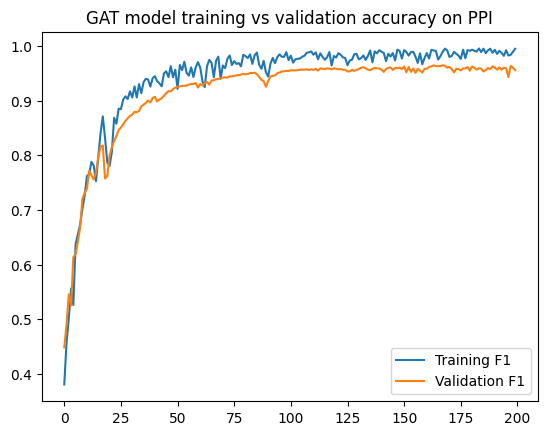

In [114]:
x = list(range(len(VAL_ACC_HIST)))

index = list(range(0, len(TRAIN_ACC_HIST), 10))
plt.plot(x, list(np.array(TRAIN_ACC_HIST)[index]), label = "Training F1")
plt.plot(x, VAL_ACC_HIST, label = "Validation F1")
plt.legend()
plt.title('GAT model training vs validation accuracy on PPI')
plt.show()